# Conservation of learnability

See Section 3 and Figure 1 in [our paper](https://arxiv.org/abs/2110.03922).

This experiment demonstrates the conservation of learnability for a fixed dataset. Informally, the dataset-learnability $\mathcal{L}^{(\mathcal{D})}(f)$ of a ground truth function $f$ is defined as the alignment between $f$ and the kernel regression estimator $\hat f$ trained on a dataset of $n$ fixed training inputs, $\mathcal{D}$, and their labels, $f(\mathcal{D})$. The conservation law states that, if we fix $\mathcal{D}$ and run ridgeless kernel regression on an orthogonal basis of target functions, the sum of $\mathcal{D}$-learnabilities over each target basis function always comes out to $n$.

$$\sum_{f\in\mathcal{F}} \mathcal{L}^{(\mathcal{D})}(f) = n$$

In our paper, we show that it is useful to set the orthogonal basis to be the eigenbasis of the kernel. In this experiment, we have a rotation-invariant kernel on the discretized unit circle, so the eigenfunctions are the sinusoids. This experiment demonstrates that the sum total of the $\mathcal{D}$-learnabilities of these eigenfunctions is $n$.

These results extend to wide neural networks in the kernel regime.

Note: this notebook is written to work in Colab, and thus it installs the `eigenlearning` repo from Github. If the repo is already present on the system, the install cell can be skipped and the modules imported directly, and the saving to Drive can be replaced with saving locally.

Please let us know if something doesn't work!

In [ ]:
import pickle

import jax
import jax.numpy as jnp
import jax.random as random

import matplotlib.gridspec as gridspec
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt

import numpy as np
!pip install -q git+https://www.github.com/google/neural-tangents

In [ ]:
import os
import sys

if os.path.isdir('/content/eigenlearning'):
    !rm -r '/content/eigenlearning'
!git clone -q https://github.com/james-simon/eigenlearning.git
sys.path.insert(0,'/content/eigenlearning')

from data import *
from expt import *
from theory import *

In [2]:
from google.colab import drive
drive.mount('/content/drive')

DIRECTORY = 'eigenlearning/'

main_dir = '/content/drive/MyDrive/' + DIRECTORY
expt_dir = main_dir + 'conservation_law/'
for dir in [main_dir, expt_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

Mounted at /content/drive


In [58]:
expt_nets = [get_net_fns(width=500, d_out=1, n_hidden_layers=1),
            get_net_fns(width=500, d_out=1, n_hidden_layers=4),
            get_net_fns(width=500, d_out=1, n_hidden_layers=1, phi=jnp.tanh, W_std=1.5, b_std=.1),
            get_net_fns(width=500, d_out=1, n_hidden_layers=4, phi=jnp.tanh, W_std=1.5, b_std=.1)]

/usr/local/lib/python3.8/dist-packages/neural_tangents/_src/stax/elementwise.py:1162: UserWarning: Numerical Activation Layer with fn=<CompiledFunction of <function jax.numpy.tanh at 0x7f5be81760d0>>, deg=40 used!Note that numerical error is controlled by `deg` and for a giventolerance level, required `deg` will highly be dependent on the choiceof `fn`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neural_tangents/_src/stax/elementwise.py:1172: UserWarning: Using JAX autodiff to compute the `fn` derivative for NTK. Beware of https://jax.readthedocs.io/en/latest/faq.html#gradients-contain-nan-where-using-where.
  warnings.warn(


In [60]:
# define NN training objective
def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean()

# Initialize unit circle data domain on 10 discrete points
M = 10
domain = UnitCircle(M)

results = {}
trainset_sizes = [3, 6]
cosine_modes = [(k,'c') for k in range(M//2 + 1)]
sine_modes = [(k,'s') for k in range(1, (M+1)//2)]
modes = cosine_modes + sine_modes
key = jnp.array([0, 42], dtype='uint32')

for i, net_fns in enumerate(expt_nets):
    for n_train in trainset_sizes:
        print(f'testing (net={i}, n_train={n_train})')

        key, dataset_key = random.split(key, 2)
        for mode in modes:
            # target represents true function f; dict mapping mode identifier -> eigencoefficient
            target = {mode: 1}
            dataset = domain.get_dataset(target, n_train, n_test=M, subkey=dataset_key)

            kernel_fn = net_fns[2]
            k_train_y_hat, k_test_y_hat = train_kernel(kernel_fn, dataset, ridge=0)
            key, subkey = random.split(key, 2)
            nn_train_y_hat, nn_test_y_hat, _ = train_net(net_fns, dataset, loss=mse, subkey=subkey,
                                                      n_epochs=10000, lr=0.5, stop_mse=1e-5)

            y_test = dataset[3]
            k_learnability = compute_metrics(y_test, k_test_y_hat)[0]
            nn_learnability = compute_metrics(y_test, nn_test_y_hat)[0]
            result = (k_learnability, nn_learnability)
            results[(i, n_train, mode[0], mode[1])] = result
    print()

with open(expt_dir+'/results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

testing (net=0, n_train=3)
testing (net=0, n_train=6)

testing (net=1, n_train=3)
testing (net=1, n_train=6)

testing (net=2, n_train=3)
testing (net=2, n_train=6)

testing (net=3, n_train=3)
testing (net=3, n_train=6)



In [62]:
with open(expt_dir+'/results.pickle', 'rb') as handle:
    results = pickle.load(handle)

# extract some metadata
n_train_vals = set()
nns = set()
modes = set()

for i, n_train, k, m in results.keys():
    nns.add(i)
    n_train_vals.add(n_train)
    modes.add((k,m))

n_train_vals = sorted(list(n_train_vals))
nns = np.array(sorted(list(nns)))
modes = list(reversed(sorted(list(modes))))

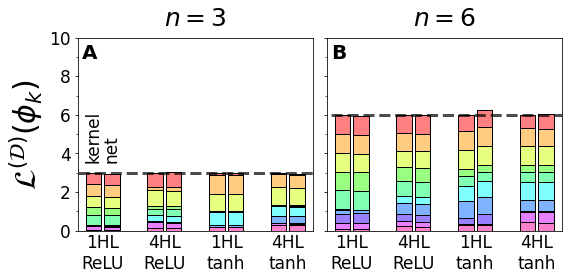

In [63]:
colors_ker = [hsv_to_rgb((1 - (i+1)/len(modes),.5,1)) for i in range(len(modes))]
colors_net = [hsv_to_rgb((1 - (i+1)/len(modes),.5,1)) for i in range(len(modes))]

fig, axs = plt.subplots(nrows=1, ncols=len(n_train_vals), figsize=(8,4))

A, B = 4, 1.2

for i, n in enumerate(n_train_vals):
    ax = axs[i]

    total_lrns_k = np.zeros_like(nns).astype(float)
    total_lrns_n = np.zeros_like(nns).astype(float)

    for j, (k, m) in enumerate(modes):
        mode_lrns_k = np.array([results[a,n,k,m][0] for a in nns])
        mode_lrns_n = np.array([results[a,n,k,m][1] for a in nns])

        ax.bar(A*nns, mode_lrns_k, width=1, bottom=total_lrns_k, color=colors_ker[j],
               edgecolor=(0,0,0), label='kernel' if j==len(modes)-1 else None)
        ax.bar(A*nns + B, mode_lrns_n, width=1, bottom=total_lrns_n, color=colors_net[j],
               edgecolor=(0,0,0), label='net' if j==len(modes)-1 else None)

        total_lrns_k += mode_lrns_k
        total_lrns_n += mode_lrns_n

    ax.plot([-10,100], [n,n], color=(0,0,0,.7), linestyle='--', lw=3)
    ax.set_xlim(-1, A*(len(nns)-1)+B+1)
    ax.set_ylim((0, 10))

    xtick_xs = []
    xtick_labels = []
    for j in nns:
        net_name = ['1HL\nReLU', '4HL\nReLU', '1HL\ntanh', '4HL\ntanh'][j]
        xtick_xs += [j*A + B/2]
        xtick_labels += [net_name]
    ax.set_xticks(xtick_xs)
    ax.set_xticklabels(xtick_labels, fontsize=17)
    ax.set_yticks(range(0,11,2), minor=False)
    ax.set_yticks(range(1,10,2), minor=True)

    ax.tick_params(axis='x', which='major', length=0)
    ax.tick_params(axis='y', which='major', labelsize=17)

    if i > 0:
        ax.set_yticklabels([])
    if i == 0:
        ax.set_ylabel(r'$\mathcal{L}^{(\mathcal{D})}(\phi_k)$', fontsize=30)

    ax.set_title(f'$n={n}$', fontsize=25, y=1.03)

    if i == 0:
        ax.text(0, 3.5, 'kernel', va='bottom', ha='center', rotation=90, fontsize=17)
        ax.text(B, 3.5, 'net', va='bottom', ha='center', rotation=90, fontsize=17)

    ax.text(.05, .89, 'AB'[i], transform=ax.transAxes, size=20, weight='bold', ha='center')

fig.tight_layout()
plt.show()
# plt.savefig('conservation_of_lrn.pdf')